## fastMRI multi-label classifier

This is a pretext task so that the classifier learns features useful in reconstructing a slice from neighboring slices. 

Task:

- Input x: a sequence of neighboring MR slices $abcde$ in shuffled order (such as $dabce$)
- Target y: a pair-wise classification of which slices come earlier in the sequence.

It is exactly analagous to giving as input a clip of randomly shuffled movie scenes and asking the classifier to put the scenes in the correct time-order.

Example:

Suppose we have 5 neighboring slices $abcde$. We shuffle and give as input the 5 slices in the order of $dabce$. Looking at the features in the slices, the classifier should figure out that the slice labelled $a$ (at index 1 in the input) should actually come before slice $d$ (at index 0 in the input). The full target label is:

| Pair (indices) | Pair (values at index) | Label (Is pair out-of-order?) |
|----------------|------------------------|--------------------------------|
| (0,1)          | d vs a                 | 1                              |
| (0,2)          | d vs b                 | 1                              |
| (0,3)          | d vs c                 | 1                              |
| (0,4)          | d vs e                 | 0                              |
| (1,2)          | a vs b                 | 0                              |
| (1,3)          | a vs c                 | 0                              |
| (1,4)          | a vs e                 | 0                              |
| (2,3)          | b vs c                 | 0                              |
| (2,4)          | b vs e                 | 0                              |
| (3,4)          | c vs e                 | 0                              |

Note: I do pair-wise classification because it yields a granular loss function: given that the target answer is $1110000000$, clearly $1100000000$ is a much better prediction than $0000111111$. The loss function is simply binary cross-entropy with respect to the pairwise labels -- each predicted value in the label can be interpreted as the probability of those two slices being out-of-order.

Potential Trouble: perhaps it only learns relatize sizes and not more relevant anatomy features that describe which slice comes first?

## Setup

In [3]:
from google.colab import drive
from pathlib      import Path 

PROJ = "fastmri"

DO_GDRIVE_SETUP = True
DO_GITHUB_SETUP = False

def run_setup_helpers(path):
  %run "$path/common_constants_env.ipynb" # pip install fastai, fastmri, etc
  %run "$path/04_kspace_tfms.ipynb"       # get the kspace tfms
  %run "$path/Crappify_Sandwich_Tfms.ipynb"        # get P & Sandw tfms

if DO_GDRIVE_SETUP:
  ROOT = "/content/drive"     # default location for the drive
  drive.mount(ROOT)           # mount google drive at /content/drive
  
  G_PATH = Path(ROOT)/"My Drive/fastai_proj/"/PROJ  # GDRIVE path
  G_PATH.mkdir(parents=True, exist_ok=True)
  run_setup_helpers(G_PATH)

if DO_GITHUB_SETUP:
  !git clone https://github.com/RGologorsky/fastmri.git
  run_setup_helpers(PROJ)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
pip install fastai2
git clone fastMRI
pip install ISMRMRD
pip install fasMRI req
pip install runstats
sys append /content/fastMRI - for transforms T, evaluation metrics E
imports
Perm : 30124
iPerm: 12304
Label (by hand): 1   1   1   0   0   0   0   0   0   0
Label (autogen): 1.0 1.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0


In [4]:
# %run "$PROJ_PATH/04_kspace_tfms.ipynb" # get the tfms to test
# %run "$PROJ/04_kspace_tfms.ipynb"       # get the kspace tfms

Test permutation

In [5]:
orig  = np.array(["a","b","c","d", "e"])
input = np.array(["d","a","b","c", "e"])

perm = np.array([3,0,1,2,4])
iperm = P.get_inv(perm)

print("Perm : ", arr2str(perm), "\n", "iPerm: ", arr2str(iperm), sep="")

np.testing.assert_array_equal(orig[perm], input)
np.testing.assert_array_equal(input[iperm], orig)

Perm : 30124
iPerm: 12304


Testing permutation label

In [6]:
p_tfm = P(n_seq=5, rands_len=10)

orig  = np.array(["a","b","c","d", "e"])
input = np.array(["d","a","b","c", "e"])

perm = np.array([3,0,1,2,4])

hand_label = (1,1,1,0,0,0,0,0,0,0)
auto_label = p_tfm.get_label(perm)

print("Label (by hand): ", arr2str(hand_label, sep = "   "), "\n", 
      "Label (autogen): ", arr2str(auto_label, sep=" "), sep="")

np.testing.assert_array_equal(hand_label, auto_label)

Label (by hand): 1   1   1   0   0   0   0   0   0   0
Label (autogen): 1.0 1.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0


# Load raw items

Raw items: list of (fname, attribute dict), derived from fn2attr.json stored in Gdrive. The attribute dict contains relevant info such as number of slices in the given h5 file.

## Knee k-space data 

- data could come from one of 4 systems: 
  - Siemens Magnetom Skyra, 
  - Prisma, 
  - Biograph mMR, 
  - Siemens Magnetom Aera.
-  data from 2 pulse sequences:
  - coronal proton-density weighting with (PDFS, 798 scans) and 
  - without (PD, 796 scans) fat suppression 
Fat has a high signal response in MR imaging, which can make details in other regions difficult to see. Fat-suppressed scans typically have higher noise.
- multi-coil data, 15 channel knee coil array

**Coronal**: alg will learn features related to slices in the coronal axis. 
**TODO**: how to tell from XML whether the slice is w/ & wo/ fat suppression.

|            | Volumes    |             | Slices     |             |
|------------|------------|-------------|------------|-------------|

|            | Multi-coil | Single-coil | Multi-coil | Single-coil |
|------------|------------|-------------|------------|-------------|
| training   | 973        |             | 37,742     |             |
| validation | 199        |             | 7,135      |             |
| test       | 118        | 108         | 4,092      | 3,903       |
| challenge  | 104        | 92          | 3,801      | 3,305       |



In [7]:
import json

# choose dataset
ds_name = "knee_singlecoil_val"
DS2DIR = {"knee_singlecoil_val": "singlecoil_val"}

ds_path = G_PATH/"data"/DS2DIR[ds_name]

# load json
with open(ds_path/"fn2attr.json", "r") as f:
  fn2attr = json.load(f)
  fn2attr_items = L(i for i in fn2attr.items())

print(get_line("Some fn_attr items"), *fn2attr_items[:5], sep="\n")

# get saved images
hr_ims, scaled_hr_ims = open_pickle("imspaces.p", "scaled_ims.p")
 
print(f"DS: {ds_name}, no. vols: {len(fn2attr_items)}")

# load bins (to de-scale image)
with open(ds_path/"uni_bins_40.npy", 'rb') as f:
  bins    = np.load(f)
  bins_pt = torch.tensor(bins)

******Some fn_attr items******
('/content/drive/My Drive/fastai_proj/fastmri/data/singlecoil_val/file1000631.h5', {'n_slices': 40, 'kspace_shape': [40, 640, 372], 'padding_left': 19, 'padding_right': 354})
('/content/drive/My Drive/fastai_proj/fastmri/data/singlecoil_val/file1000314.h5', {'n_slices': 32, 'kspace_shape': [32, 640, 372], 'padding_left': 19, 'padding_right': 354})
('/content/drive/My Drive/fastai_proj/fastmri/data/singlecoil_val/file1000031.h5', {'n_slices': 40, 'kspace_shape': [40, 640, 372], 'padding_left': 19, 'padding_right': 354})
('/content/drive/My Drive/fastai_proj/fastmri/data/singlecoil_val/file1000480.h5', {'n_slices': 33, 'kspace_shape': [33, 640, 372], 'padding_left': 19, 'padding_right': 354})
('/content/drive/My Drive/fastai_proj/fastmri/data/singlecoil_val/file1000071.h5', {'n_slices': 35, 'kspace_shape': [35, 640, 372], 'padding_left': 19, 'padding_right': 354})
DS: knee_singlecoil_val, no. vols: 40


# Pre-process

Resize to common denominator

In [8]:
print(get_line("Some fn_attr items"), *fn2attr_items[:5], sep="\n")

kshapes = [tuple(o[1]["kspace_shape"][1:]) for o in fn2attr_items]
pads    = [(o[1]["padding_left"],o[1]["padding_right"]) for o in fn2attr_items]

print_line("KSPACE distinct shapes")
get_shapes_info(kshapes)

print_line("distinct padding")
get_shapes_info(pads)

# shapes of im volumes
print_line("IMAGE distinct shapes")

im_shapes = [im.shape[-2:] for im in hr_ims]
get_shapes_info(im_shapes);

# resize all images to same size. Either CROP to MIN DIM or PAD to MAX DIM.
crop_shape     = get_common_shape(im_shapes, do_print=True)
hr_ims_cropped = [T.center_crop(im, crop_shape) for im in hr_ims]

print_line("AFTER CENTER CROP")
hr_crop_info = get_shapes_info([im.shape[-2:] for im in hr_ims_cropped])


******Some fn_attr items******
('/content/drive/My Drive/fastai_proj/fastmri/data/singlecoil_val/file1000631.h5', {'n_slices': 40, 'kspace_shape': [40, 640, 372], 'padding_left': 19, 'padding_right': 354})
('/content/drive/My Drive/fastai_proj/fastmri/data/singlecoil_val/file1000314.h5', {'n_slices': 32, 'kspace_shape': [32, 640, 372], 'padding_left': 19, 'padding_right': 354})
('/content/drive/My Drive/fastai_proj/fastmri/data/singlecoil_val/file1000031.h5', {'n_slices': 40, 'kspace_shape': [40, 640, 372], 'padding_left': 19, 'padding_right': 354})
('/content/drive/My Drive/fastai_proj/fastmri/data/singlecoil_val/file1000480.h5', {'n_slices': 33, 'kspace_shape': [33, 640, 372], 'padding_left': 19, 'padding_right': 354})
('/content/drive/My Drive/fastai_proj/fastmri/data/singlecoil_val/file1000071.h5', {'n_slices': 35, 'kspace_shape': [35, 640, 372], 'padding_left': 19, 'padding_right': 354})
****KSPACE distinct shapes****
Unique Sizes & Counts: 
(array([640, 372]), 37, 0)
(array([640,

Testing scaling/inverse function

In [9]:
print("Min bins: ", min(bins), "Max bins: ", max(bins))
num = torch.tensor(3e-5)
scaled_num = hist_scaled_pt(num, bins_pt)
inv_num = inv_hist_scaled_pt(scaled_num, bins_pt)

print(f"Original: {num}, Inverse: {inv_num}, Scaled: {scaled_num}, Diff: {num-inv_num}")
np.testing.assert_almost_equal(num, inv_num)

Min bins:  3.3871757e-07 Max bins:  0.000256547
Original: 2.9999999242136255e-05, Inverse: 3.0000002880115062e-05, Scaled: 0.7698639631271362, Diff: -3.637978807091713e-12


Testing scaline/inverse on an MR image

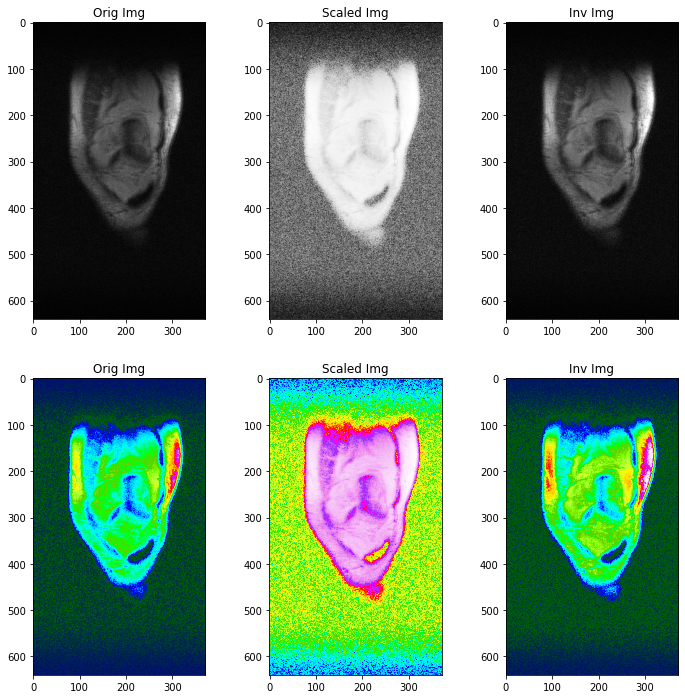

In [10]:
vol_idx, slice_idx = 20, 10

orig_im   = hr_ims[vol_idx][slice_idx]
scaled_im = scaled_hr_ims[vol_idx][slice_idx]
inv_im    = inv_hist_scaled_pt(scaled_im, bins_pt)

ims    = [orig_im, scaled_im, inv_im]
titles = ["Orig Img", "Scaled Img", "Inv Img"]

fig, axes = plt.subplots(nrows = 2, ncols=3, figsize=(12,12))
for cmap,row in zip(cmap_options, axes):
  for im,title,ax in zip(ims, titles, row): 
    ax.imshow(im, cmap=cmap)
    ax.set_title(title)

#cmap_options = ["gray", plt.cm.gist_ncar]
# with h5py.File(fn2attr_items[vol_idx][0], 'r') as f:
#   orig_im = C.apply(f['kspace'][()][slice_idx], CenteredTfms.k2im(), pre=T.to_tensor, post=C.complex2mgn)  

Is there a way to get kspaces same shape without so much wasted padding pixels?

# Datasets

In [11]:
#sandw_tfm  = ImSandwP(fn2attr_items, objs = scaled_hr_ims, n_seq=5)
sandw_tfm  = ImSandwP(fn2attr_items, objs = hr_ims_cropped, n_seq=5)

# setup the transform
print(f"total #slices     = {sandw_tfm.total_n_slices}")
print(f"total #sandwiches = {sandw_tfm.total_n_sandws}")

# dataset = indices, sandw_tfm converts index to sandwich
raw_items = range(sandw_tfm.total_n_sandws)

# split between training/valid
splitter = RandomSplitter(valid_pct=0.2, seed=42)
splits   = splitter(raw_items)
print(f"#train/#valid = {len(splits[0]), len(splits[1])}")

# magn im space sandw
%time im_ds = TfmdLists(raw_items, tfms=[sandw_tfm], splits=splits)

total #slices     = 1356
total #sandwiches = 1196
#train/#valid = (957, 239)
CPU times: user 5.4 ms, sys: 0 ns, total: 5.4 ms
Wall time: 5.72 ms


## Viz datasets

In [12]:
import string
ascii = np.array(list(string.ascii_lowercase))

i            = np.random.randint(len(im_ds))
sandw, label = im_ds[i]
label = tuple(label.numpy())

print(f"Sandwich {i} (shape {sandw.shape})")

perm     = sandw_tfm.perms[sandw_tfm.o2i[label]]
perm_arr = np.array(perm)
perm_inv = P.get_inv(perm_arr)

print_line("Permuation")
print("P    ", perm_arr)
print("P Inv", perm_inv)
print("Label", label)

input = ascii[perm_arr]
orig  = input[perm_inv]
letter_pairs = [ascii[perm_arr[i]] + ascii[perm_arr[j]] for i,j in sandw_tfm.pairs]

print_line("Letters")
print("Input", arr2str(input))
print("Orig ", arr2str(orig))
print("Label", list(zip(letter_pairs, label)))

# plot input sandwich + target slice
n_seq = sandw_tfm.n_seq

# MRs in (magnitude) image space
ims  = toL(sandw) + toL(sandw[perm_inv])
titles  = [f"Input {i}" for i in input] + [f"Target {i}" for i in orig] #range(sandw_tfm.n_seq)]

plot(ims, titles, nrows=2, ncols=sandw_tfm.n_seq, figsize=(12,12), cmaps=cmaps[1])

Sandwich 1046 (shape torch.Size([5, 640, 372]))
**********Permuation**********
P     [3 1 4 2 0]
P Inv [4 1 3 0 2]
Label (1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0)
***********Letters************
Input dbeca
Orig  abcde
Label [('db', 1.0), ('de', 0.0), ('dc', 1.0), ('da', 1.0), ('be', 0.0), ('bc', 0.0), ('ba', 1.0), ('ec', 1.0), ('ea', 1.0), ('ca', 1.0)]


NameError: ignored

# Dataloaders

In [ ]:
# parameters
bs          = 16
num_workers = 1

# tfms 
aug_tfms   = [] #[RandomDihedral(tfm_y=TfmType.PIXEL)]
item_tfms  = []
batch_tfms = [] # No normalization 

# dls
im_dls = im_ds.dataloaders(
          after_item  = item_tfms, 
          after_batch = batch_tfms, 
          bs=bs, 
          num_workers = num_workers).cuda()

## Viz dls

In [ ]:
import string
ascii = np.array(list(string.ascii_lowercase))

xb,yb = im_dls.one_batch()
xb, yb = to_cpu(xb), to_cpu(yb)

print(f"Batch Shape: xb {xb.shape}, yb {yb.shape}")

sandw, label = xb[0], tuple(yb[0].numpy())
print(sandw.shape, label)

print(f"Sandwich {i} (shape {sandw.shape})")

perm     = sandw_tfm.perms[sandw_tfm.o2i[label]]
perm_arr = np.array(perm)
perm_inv = P.get_inv(perm_arr)

print_line("Permuation")
print("P    ", perm_arr)
print("P Inv", perm_inv)
print("Label", label)

input = ascii[perm_arr]
orig  = input[perm_inv]
letter_pairs = [ascii[perm_arr[i]] + ascii[perm_arr[j]] for i,j in sandw_tfm.pairs]

print_line("Letters")
print("Input", arr2str(input))
print("Orig ", arr2str(orig))
print("Label", list(zip(letter_pairs, label)))

# plot input sandwich + target slice
n_seq = sandw_tfm.n_seq

# MRs in (magnitude) image space
ims  = toL(sandw) + toL(sandw[perm_inv])
titles  = [f"Input {i}" for i in input] + [f"Target {i}" for i in orig] #range(sandw_tfm.n_seq)]

plot(ims, titles, nrows=2, ncols=sandw_tfm.n_seq, figsize=(12,6), cmaps=cmaps[1])

In [ ]:
#im_dls.train_ds.tfms

# x = im_dls.train_ds

# x.tfms[0].rands
# x.tfms[0].set_rands()
# x.tfms[0].rands

#im_dls.train_ds.tfms

# print(*[(i,lr_dls.train_ds[i][0].shape) for i in range(10)], sep="\n")

# lr_dls.train_ds
# lr_dls.train_ds.tfms -- list of tfms

# Model

In [34]:
# ARCHITECTURE
c_in  = sandw_tfm.n_seq
n_out = c_in * (c_in - 1)//2

print(f"Channels in: {c_in}, Channels out: {n_out}")

Channels in: 5, Channels out: 10


In [14]:
import numpy as np

In [17]:
math.log??

In [20]:
# rounds x to power of 2
def round_pow_2(x): return pow(2, int(math.log(x,2)))
print(*[round_pow_2(x) for x in range(1,10)])

1 2 2 4 4 4 4 8 8


In [13]:
crop_shape

(640, 372)

In [21]:
noop(2)

2

In [ ]:
# ARCHITECTURE

#xresnet_arch  = xresnet34(c_in=c_in, n_out=n_out, pretrained=False)

# VGG. Factored convs instead of Flatten. Stride 1 computation in beginning.

cfg = [
       16, 16, 'M', # 640 x 372; stride-1 5x5 receptive field (two 3x3 conv)
       32, 32, 'M', # 320 x 180
       64, 64, 'M', # 160 x 90
       128, 128, 'M', # 80 x 45
       256, 256, 256, 'M', # 40 x 22
       512, 512, 512, 'M'] # 20 x 11

# backbone number of features
n_feat_bb = cfg[-2]

# classifer after backbone
n_feat_head = c_out
print("N features in Head/Classifier: ", n_feat_head)

# pretrained weights
MODEL_DIR     = G_PATH/"models"
PRETRAIN_FN   = "SandwClassifierRAM-epoch15-norm-no-presize.pth"

class TweakVGG(nn.Module):

    def __init__(self, features, n_feat_bb=n_feat_bb, n_feat_head = n_feat_head, c_out, init_weights=True):
        super(VGG, self).__init__()
        self.features = features
        self.avgpool = noop #nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
          nn.Conv2d(n_feat_bb, n_feat_head,   kernel_size=(1,7), padding=3)
          nn.Conv2d(n_feat_head, n_feat_head, kernel_size=(7,1), padding=3)
          nn.ReLU(True),
          nn.Dropout(),
          nn.Linear(n_feat_head, n_feat_head),
          nn.ReLU(True),
          nn.Dropout(),
          nn.Linear(n_feat_head, c_out),
        )

        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


def make_layers(cfg, in_channels = c_in, batch_norm=False):
    layers = []
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


def _vgg(arch, cfg, batch_norm, pretrained, **kwargs):
    if pretrained: kwargs['init_weights'] = False
    model = VGG(make_layers(cfgs[cfg], in_channels = c_in, batch_norm=batch_norm), **kwargs)
    if pretrained:
        state_dict = torch.load(MODEL_DIR/PRETRAIN_FN)
        model.load_state_dict(state_dict["model"])
    return model


def vgg16_bn(pretrained=False, progress=True, **kwargs):
    r"""VGG 16-layer model (configuration "D") with batch normalization
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg('vgg16_bn', 'D', True, pretrained, **kwargs)


Channels in: 5, Channels out: 10


In [ ]:
# LOSS FUNC
loss_func = nn.BCEWithLogitsLoss()

In [ ]:
# METRICS
def accuracy_multi(inp, targ, thresh=0.8, sigmoid=True):
  "Compute accuracy when `inp` and `targ` are the same size."
  if sigmoid: inp = inp.sigmoid()
  return ((inp>thresh)==targ.bool()).float().mean()

accuracy_multi_thresh = partial(accuracy_multi, thresh=0.5)

metrics = [accuracy_multi_thresh]

In [ ]:
# CALLBACKS

from fastai2.callback.hook import *

# re-shuffle sandwich for each epoch
class EpochPermute(Callback):
  def begin_epoch(self): sandw_tfm.set_rands()

cbs = [EpochPermute] #ActivationStats(with_hist=True)

In [ ]:
# IMPORT/EXPORT WEIGHTS
EXPORT_DIR = G_PATH/"models"

# save model's trained weights
def export(learn, name, id): 
  learn.export(f"{EXPORT_DIR}/{name}-{id}-export.pkl")

def load(name, id, cpu=False):
  return load_learner(f"{EXPORT_DIR}/{name}-{id}-export.pkl", cpu=cpu)

In [ ]:
# LEARNER (TODO: tofp16?)
learn = Learner(im_dls, arch.cuda(), loss_func, metrics=metrics, cbs=cbs)

In [ ]:
%time xb,yb = im_dls.train.one_batch()
xb.shape, yb.shape

CPU times: user 67.5 ms, sys: 8 ms, total: 75.5 ms
Wall time: 78.2 ms


(torch.Size([16, 5, 640, 372]), torch.Size([16, 10]))

In [ ]:
activs = learn.model(xb)
print("Shape", activs.shape)

print_line("Model Activations")
print("Batch Item 0: ", activs[0])
print("Batch Item 0 (sigmoid): ", activs[0].sigmoid())
print("Target Item 0: ", yb[0])

#activs.sigmoid()

print_line("Accuracy")
acc0 = accuracy_multi_thresh(activs,yb[0])
acc = accuracy_multi_thresh(activs,yb)
print("Accuracy Item 0: ", acc0)
print("Batch Accuracy:", acc)

Shape torch.Size([16, 10])
******Model Activations*******
Batch Item 0:  tensor([-0.1465,  0.6748, -0.2440, -0.4355, -0.2268,  0.2817, -0.6493, -0.2674,
        -0.2923, -0.7457], device='cuda:0', grad_fn=<SelectBackward>)
Batch Item 0 (sigmoid):  tensor([0.4635, 0.6626, 0.4393, 0.3928, 0.4435, 0.5700, 0.3432, 0.4335, 0.4274,
        0.3218], device='cuda:0', grad_fn=<SigmoidBackward>)
Target Item 0:  tensor([0., 0., 0., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
***********Accuracy***********
Accuracy Item 0:  tensor(0.2500, device='cuda:0')
Batch Accuracy: TensorMultiCategory(0.5000, device='cuda:0')


# Train

In [ ]:
# learn = Learner(im_dls, arch.cuda(), loss_func, metrics=metrics, cbs=cbs)

In [ ]:
#learn.freeze()
learn.freeze()

In [ ]:
learn = learn.load(PATH)
PATH

Path('/content/drive/My Drive/fastai_proj/fastmri/models/SandwClassifierRAM-epoch15-opt-norm_and_presize')

In [ ]:
learn.dls = im_dls

SuggestedLRs(lr_min=0.002754228748381138, lr_steep=0.007585775572806597)

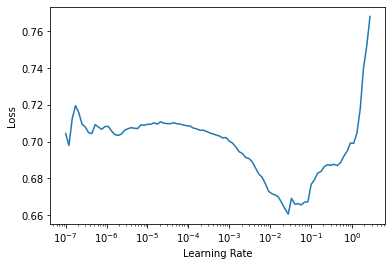

In [ ]:
learn.lr_find()

In [ ]:
# Train model head (FROM SCRATCH, not pretrained)
learn.freeze()
learn.fit_one_cycle(n_epoch=10, lr=3e-3)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.413064,0.347491,0.859833,00:28
1,0.424697,0.488868,0.775732,00:28
2,0.434925,0.476533,0.788284,00:29
3,0.431837,0.526576,0.764017,00:30
4,0.416292,0.435015,0.806276,00:30
5,0.409214,0.341097,0.852301,00:29
6,0.396151,0.296387,0.891214,00:29
7,0.376066,0.302853,0.881590,00:30
8,0.361272,0.275014,0.903766,00:30
9,0.358166,0.271771,0.900000,00:30


In [ ]:
# Train full model
learn.unfreeze()
learn.fit_one_cycle(4, slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.351433,0.268544,0.906276,00:29
1,0.345184,0.277164,0.892469,00:30
2,0.346155,0.262230,0.907531,00:30
3,0.345322,0.251828,0.916736,00:29


In [ ]:
# PRESIZE
learn.freeze()
learn.fine_tune(epochs=5, lr=1e-4)

In [ ]:
# PRESIZE
learn.freeze()
learn.fine_tune(epochs=5, lr=1e-4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.493762,4.251744,0.535983,01:07


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.448365,2.028353,0.547699,01:06
1,0.450036,4.482886,0.541423,01:06
2,0.445509,0.405180,0.806276,01:06
3,0.400059,0.402005,0.799582,01:06
4,0.384767,0.281158,0.907113,01:06


In [ ]:
torch.cuda.empty_cache()

In [ ]:
# learn.model

In [ ]:
# state = get_model(learn.model).state_dict()

In [ ]:
learn.model_dir = G_PATH/"models"

FN   = "SandwClassifierRAM-epoch15-norm-no-presize"
PATH = learn.model_dir/FN
PATH

Path('/content/drive/My Drive/fastai_proj/fastmri/models/SandwClassifierRAM-epoch15-norm-no-presize')

In [ ]:
# torch.save({
#             'epoch': 10,
#             'model_state_dict': learn.model.state_dict(),
#             'optimizer_state_dict': learn.opt.state_dict()
#             }, PATH)

In [ ]:
learn.save(FN)

# Reload & train some more

In [ ]:
learn.fit_one_cycle(n_epoch=10, lr=3e-3)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.401033,0.360425,0.844770,00:54
1,0.416766,2.993711,0.584937,00:53
2,0.429279,2.579956,0.575314,00:52
3,0.415794,0.496767,0.778243,00:51
4,0.407996,1.882211,0.606276,00:51
5,0.401110,0.433248,0.786611,00:51
6,0.376146,0.621843,0.734310,00:51
7,0.354916,0.279751,0.891213,00:51
8,0.339162,0.250928,0.912971,00:51
9,0.323398,0.245365,0.915481,00:51


In [ ]:
torch.cuda.empty_cache()

In [ ]:
learn.save("sandwClassifier-epoch20-fastai-save.pt")

# Scaling/Normalizing Data

In [ ]:
scaled_ims[0].type, scaled_ims[0].shape

(<function Tensor.type>, torch.Size([40, 640, 372]))

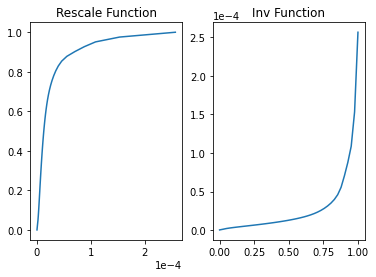

In [ ]:
fig, (ax0,ax1) = plt.subplots(ncols=2)

ys = torch.linspace(0,1,len(bins))

ax0.plot(bins, ys)
ax0.set_title("Rescale Function");
ax0.ticklabel_format(axis="x", style="sci", scilimits=(0,0))

ax1.plot(ys, bins)
ax1.set_title("Inv Function")
ax1.ticklabel_format(axis="y", style="sci", scilimits=(1,0))

Testing scaling/inverse function

In [ ]:
print("Min bins: ", min(bins), "Max bins: ", max(bins))
num = torch.tensor(3e-5)
scaled_num = hist_scaled_pt(num, bins_pt)
inv_num = inv_hist_scaled_pt(scaled_num, bins_pt)

print(f"Original: {num}, Inverse: {inv_num}, Scaled: {scaled_num}, Diff: {num-inv_num}")
np.testing.assert_almost_equal(num, inv_num)

Min bins:  3.3871757e-07 Max bins:  0.000256547
Original: 2.9999999242136255e-05, Inverse: 3.0000002880115062e-05, Scaled: 0.7698639631271362, Diff: -3.637978807091713e-12


Testing scaline/inverse on an MR image

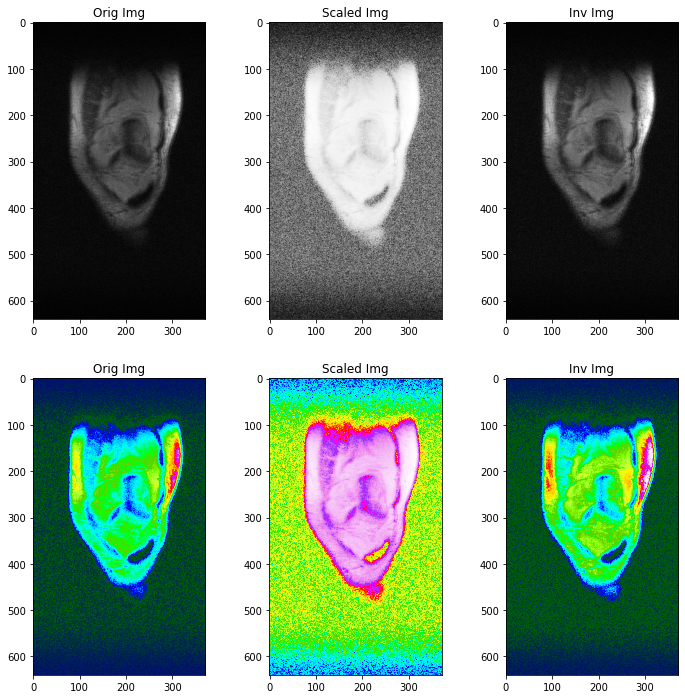

In [ ]:
vol_idx, slice_idx = 20, 10

orig_im   = hr_ims[vol_idx][slice_idx]
scaled_im = scaled_hr_ims[vol_idx][slice_idx]
inv_im    = inv_hist_scaled_pt(scaled_im, bins_pt)

ims    = [orig_im, scaled_im, inv_im]
titles = ["Orig Img", "Scaled Img", "Inv Img"]

fig, axes = plt.subplots(nrows = 2, ncols=3, figsize=(12,12))
for cmap,row in zip(cmap_options, axes):
  for im,title,ax in zip(ims, titles, row): 
    ax.imshow(im, cmap=cmap)
    ax.set_title(title)

#cmap_options = ["gray", plt.cm.gist_ncar]
# with h5py.File(fn2attr_items[vol_idx][0], 'r') as f:
#   orig_im = C.apply(f['kspace'][()][slice_idx], CenteredTfms.k2im(), pre=T.to_tensor, post=C.complex2mgn)  

Is there a way to get kspaces same shape without so much wasted padding pixels?

In [ ]:
#sandw_tfm  = ImSandwP(fn2attr_items, objs = scaled_hr_ims, n_seq=5)
# sandw_tfm  = ImSandwP(fn2attr_items, objs = hr_ims, n_seq=5)

# Normalize Data

Sources: https://www.kaggle.com/jhoward/don-t-see-like-a-radiologist-fastai#Creating-a-normalized-dataset

Distr of min/max values in each volume -- how often do extreme values occur

In [ ]:
# https://www.kaggle.com/jhoward/some-dicom-gotchas-to-be-aware-of-fastai
# https://www.kaggle.com/jhoward/creating-a-metadata-dataframe-fastai

def distrib_summ(t):
  plt.hist(t,40)
  return array([t.min(),*np.percentile(t,[0.1,1,5,50,95,99,99.9]),t.max()], dtype=np.int)

# Viz min/max pixel values of each image volume
extreme_px_vals = [(t.min(), t.max()) for t in sandw_tfm.objs]
min_px_vals, max_px_vals = zip(*extreme_px_vals)
min_px_vals, max_px_vals = torch.stack(min_px_vals), torch.stack(max_px_vals)
print(min_px_vals, max_px_vals)

distrib_summ(min_px_vals)
distrib_summ(max_px_vals)


(tensor([3.7433e-09, 2.9861e-09, 4.6084e-09, 5.2713e-10, 1.1071e-08, 4.1917e-09,
         5.4532e-09, 5.4559e-09, 9.1486e-09, 3.3707e-09, 5.2895e-09, 7.4359e-10,
         2.7446e-09, 2.6286e-09, 2.4367e-09, 4.3209e-09, 5.9645e-09, 7.2316e-09,
         2.7040e-09, 2.1935e-09, 4.4071e-09, 1.6431e-09, 2.3583e-09, 3.6235e-09,
         4.0599e-09, 4.1492e-09, 3.0435e-09, 5.4120e-09, 1.8491e-09, 1.8676e-09,
         4.2582e-09, 2.1671e-09, 1.1551e-09, 2.7437e-09, 3.7118e-09, 4.9831e-09,
         6.2528e-09, 5.1834e-09, 2.2207e-09, 3.3881e-09]),
 tensor([0.0002, 0.0006, 0.0004, 0.0002, 0.0005, 0.0008, 0.0007, 0.0002, 0.0001,
         0.0001, 0.0005, 0.0005, 0.0004, 0.0005, 0.0002, 0.0001, 0.0001, 0.0002,
         0.0003, 0.0002, 0.0006, 0.0003, 0.0005, 0.0003, 0.0002, 0.0006, 0.0001,
         0.0003, 0.0006, 0.0003, 0.0003, 0.0003, 0.0003, 0.0002, 0.0001, 0.0005,
         0.0003, 0.0002, 0.0002, 0.0007]))

Mean/std, distribution of all pixels (all volumes flattened together)

In [ ]:
all_px = torch.cat([torch.flatten(t) for t in sandw_tfm.objs], dim=0)
np_all_px = all_px.numpy()

px_stats = all_px.mean(), all_px.std()

print(f"Total: {all_px.shape}", f"Mean/Std: {px_stats}", sep="\n")
plt.hist(all_px, bins=40)


Histogram that has about same number of pixels in each bin

In [ ]:
# from https://github.com/fastai/fastai_dev/blob/master/dev/60_medical_imaging.ipynb

def array_freqhist_bins(self, n_bins=100):
    "A numpy based function to split the range of pixel values into groups, such that each group has around the same number of pixels"
    imsd = np.sort(self.flatten())
    t = np.array([0.001])
    t = np.append(t, np.arange(n_bins)/n_bins+(1/2/n_bins))
    t = np.append(t, 0.999)
    t = (len(imsd)*t+0.5).astype(np.int)
    return np.unique(imsd[t])

def freqhist_bins(self:Tensor, n_bins=100):
    "A function to split the range of pixel values into groups, such that each group has around the same number of pixels"
    imsd = self.view(-1).sort()[0]
    t = torch.cat([tensor([0.001]),
                   torch.arange(n_bins).float()/n_bins+(1/2/n_bins),
                   tensor([0.999])])
    t = (len(imsd)*t).long()
    return imsd[t].unique()


In [ ]:
# bins = freqhist_bins(all_px, bins=10 or 20 or 40)
# print(bins)
# plt.hist(all_px, bins=bins)

Scale pixel values evenly using above bins via function which connects these bins with line segments, like this:

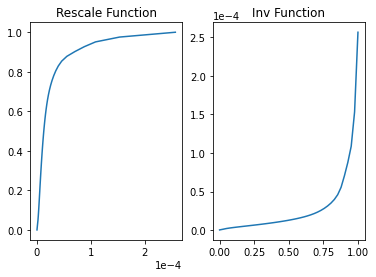

In [ ]:
fig, (ax0,ax1) = plt.subplots(ncols=2)

ys = torch.linspace(0,1,len(bins))

ax0.plot(bins, ys)
ax0.set_title("Rescale Function");
ax0.ticklabel_format(axis="x", style="sci", scilimits=(0,0))

ax1.plot(ys, bins)
ax1.set_title("Inv Function")
ax1.ticklabel_format(axis="y", style="sci", scilimits=(1,0))

Total: torch.Size([331045120])
Mean/Std: (tensor(0.4995), tensor(0.2815))


(array([4294822., 8492505., 8491615., 8491190., 8488953., 8491798.,
        8490332., 8491833., 8486084., 8488902., 8491405., 8486010.,
        8486339., 8486603., 8491094., 8488220., 8487581., 8487447.,
        8488106., 8489567., 8492992., 8490907., 8493330., 8490811.,
        8493950., 8492193., 8490926., 8487696., 8482231., 8476158.,
        8476162., 8483444., 8500511., 8519879., 8511410., 8365985.,
        8409954., 8554249., 8485744., 4256182.]),
 array([0.   , 0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  ,
        0.225, 0.25 , 0.275, 0.3  , 0.325, 0.35 , 0.375, 0.4  , 0.425,
        0.45 , 0.475, 0.5  , 0.525, 0.55 , 0.575, 0.6  , 0.625, 0.65 ,
        0.675, 0.7  , 0.725, 0.75 , 0.775, 0.8  , 0.825, 0.85 , 0.875,
        0.9  , 0.925, 0.95 , 0.975, 1.   ], dtype=float32),
 <a list of 40 Patch objects>)

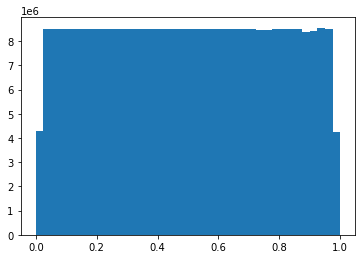

In [ ]:
# scaled_ims = tuple(hist_scaled_pt(o, tensor(bins)) for o in sandw_tfm.objs)
# len(scaled_ims), scaled_ims[0].shape

# save scaled ims
# import pickle
# pickle.dump(scaled_ims, open(path_ds/"scaled_ims.p", 'wb'))
# #np.save(path_out, np.asarray(scaled_ims))

# check distribution is Uniform
all_scaled = torch.cat([torch.flatten(t) for t in scaled_ims], dim=0)
scaled_stats = all_scaled.mean(), all_scaled.std()

print(f"Total: {all_scaled.shape}", f"Mean/Std: {scaled_stats}", sep="\n")
plt.hist(all_scaled, bins=40)

Test ImSandwP

In [ ]:
perm = np.array([3,0,1,2,4])

hand_label = (1,1,1,0,0,0,0,0,0,0)
auto_label = sandw_tfm.get_label(perm)

print("Label (by hand): ", arr2str(hand_label, sep = "   "), "\n", 
      "Label (autogen): ", arr2str(auto_label, sep=" "), sep="")

np.testing.assert_array_equal(hand_label, auto_label)

Label (by hand): 1   1   1   0   0   0   0   0   0   0
Label (autogen): 1.0 1.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0


Test P.set_rands()

In [ ]:
rands0     = sandw_tfm.rands
enc_sandw0 = sandw_tfm.encodes(0)
dec_sandw0 = sandw_tfm.decodes(enc_sandw0)

sandw_tfm.set_rands()

rands1     = sandw_tfm.rands
enc_sandw1 = sandw_tfm.encodes(0)
dec_sandw1 = sandw_tfm.decodes(enc_sandw1)

print_line("Rands")
print(arr2str(rands0[:3], sep=", "), "\n", arr2str(rands1[:3], sep=", "), sep="")

print_line("First item")
print("Encoded", enc_sandw0[1].numpy(), "Decoded", dec_sandw0[1])
print("Encoded", enc_sandw1[1].numpy(), "Decoded", dec_sandw1[1])


************Rands*************
40, 3, 83
73, 96, 39
**********First item**********
Encoded [0. 0. 1. 0. 0. 1. 1. 1. 1. 0.] Decoded (1, 3, 4, 0, 2)
Encoded [1. 1. 0. 1. 0. 0. 0. 0. 0. 1.] Decoded (3, 0, 1, 4, 2)


# Old

In [ ]:
    # load kspaces into RAM for faster lookup
    # self.kspaces = []
    # for fname,_ in fn2attr_items:
    #   with h5py.File(fname, 'r') as f:
    #     self.kspaces.append(f['kspace'][()])

    # get kspace sandwich, target slice + neighbor slices on either side
    ksandw  = self.kspaces[fn_idx][sw_idx:sw_idx+self.n_seq]     
    imsandw = C.apply(ksandw, CenteredTfms.k2im(), pre=T.to_tensor, post=C.complex2mgn)

    # class RAMDataset(Dataset):
#   def __init__(fnames):
#     self.kspaces = []
#     for fname in fnames:
#       # get kspace sandwich, target slice + neighbor slices on either side
#       with h5py.File(fname, 'r') as f:
#         self.kspaces.append(f['kspace'][()])
    
#   def __len__(self):
#     return len(self.kspaces)
  
#   def __getitem__(self, index):
#     return self.kspaces[index]


In [ ]:
# indexes into array of kspace slices
class ImSandwP(Transform, P):

  def __init__(self, fn2attr_items, n_seq = 5):
    self.n_seq = n_seq
    self.fn2attr_items = fn2attr_items
   
    # how many slices/sandwiches per file
    self.n_slices = [attr["n_slices"] for (_, attr) in self.fn2attr_items]
    self.n_sandws = [n-(self.n_seq-1) for n in self.n_slices]

    # given dataset index, cumsum is used to index into appropriate file
    self.cumsum_n_slices = np.cumsum(self.n_slices)
    self.cumsum_n_sandws = np.cumsum(self.n_sandws)

    # total number of slices/sandwiches in dataset (for reference)
    self.total_n_slices   = self.cumsum_n_slices[-1]
    self.total_n_sandws   = self.cumsum_n_sandws[-1]

    #  choose which permutation to use for each sandw (avoid call to rand repeated)
    P.__init__(self, n_seq=self.n_seq, rands_len=self.total_n_sandws)

    # load kspaces into RAM
    # self.kspaces = []
    # for fname,_ in fn2attr_items:
    #   with h5py.File(fname, 'r') as f:
    #     self.kspaces.append(f['kspace'][()])

  # returns index in fn2attr corresponding to given sandwich
  def sandw2fn_idx(self, i): return np.searchsorted(self.cumsum_n_sandws, i)
  
  def encodes(self, sandw_idx):
    # sandw number (idx 0 = first sandwich = sandwich #1)
    sandw_number = sandw_idx + 1
    
    # get file
    fn_idx  = self.sandw2fn_idx(sandw_number)
    fname   = self.fn2attr_items[fn_idx][0]

    # sandwich index within file
    n_sandw_prior_vol = 0 if fn_idx == 0 else self.cumsum_n_sandws[fn_idx - 1]
    sw_idx  = sandw_idx - n_sandw_prior_vol # 15sandw in file = 14th index
    
    # get kspace sandwich, target slice + neighbor slices on either side
    with h5py.File(fname, 'r') as f:
      ksandw  = f['kspace'][sw_idx:sw_idx+self.n_seq]     
      imsandw = C.apply(ksandw, CenteredTfms.k2im(), pre=T.to_tensor, post=C.complex2mgn)

    # shuffle ksandw according to permutation
    perm, label = self.get_perm(sandw_idx)
    return imsandw[np.array(perm)], label

  def decodes(self, o):
    imsandw, label = o
    return imsandw, self.perms[self.o2i[label]]

In [ ]:
# indexes into array of kspace slices
class ImSandwP(Transform, P):

  # returns index in fn2attr corresponding to given sandwich
  def sandw2fn_idx(self, i): return np.searchsorted(self.cumsum_n_sandws, i)
  
  # choose which permutation to use for each sandw (to avoid calling random repeatedly)
  def set_rands(self):
    self.rands = np.random.randint(self.c, size=self.total_n_sandws)

  def __init__(self, fn2attr_items, n_seq = 5):

    # permutations
    self.n_seq = n_seq
    self.c     = math.factorial(n_seq)
    self.vocab = CategoryMap([P.arr2str(p) for p in permutations(range(n_seq))])

    # fnames, volumes, slices, sandws, etc
    self.fn2attr_items = fn2attr_items
   
    # how many slices/sandwiches per file
    self.n_slices = [attr["n_slices"] for (_, attr) in self.fn2attr_items]
    self.n_sandws = [n-(self.n_seq-1) for n in self.n_slices]

    # given dataset index, cumsum is used to index into appropriate file
    self.cumsum_n_slices = np.cumsum(self.n_slices)
    self.cumsum_n_sandws = np.cumsum(self.n_sandws)

    # total number of slices/sandwiches in dataset (for reference)
    self.total_n_slices   = self.cumsum_n_slices[-1]
    self.total_n_sandws   = self.cumsum_n_sandws[-1]

    #  choose which permutation to use for each sandw (avoid call to rand repeated)
    self.set_rands()

  def encodes(self, sandw_idx):
    # sandw number (idx 0 = first sandwich = sandwich #1)
    sandw_number = sandw_idx + 1
    
    # get file
    fn_idx  = self.sandw2fn_idx(sandw_number)
    fname   = self.fn2attr_items[fn_idx][0]

    # sandwich index within file
    n_sandw_prior_vol = 0 if fn_idx == 0 else self.cumsum_n_sandws[fn_idx - 1]
    sw_idx  = sandw_idx - n_sandw_prior_vol # 15sandw in file = 14th index
    
    # get kspace sandwich, target slice + neighbor slices on either side
    with h5py.File(fname, 'r') as data:
      ksandw = data['kspace'][sw_idx:sw_idx+self.n_seq]      
    
    # shuffle ksandw according to permutation
    rand     = self.rands[sandw_idx] # rand \in [0,n_seq!]
    perm_str = self.vocab[rand]
    perm_arr = P.str2arr(perm_str)

    ksandw  = T.to_tensor(ksandw[perm_arr])
    imsandw = C.apply(ksandw, CenteredTfms.k2im(), post=C.complex2mgn)

    return imsandw, TensorCategory(rand)

  def decodes(self, o):
    perm_ksandw, perm_category = o
    return perm_ksandw, self.vocab[perm_category]

In [ ]:
# converts complex k-space (2channel) to magnitude-only k-space (1channel)
class K2ImTfm(Transform):
  def encodes(self, t:TensorCategory): return t
  def encodes(self, t:Tensor): return C.apply(t, CenteredTfms.k2im(), post=C.complex2mgn)

In [ ]:
# indexes into array of kspace slices
class SandwP(Transform, P):

  # returns index in fn2attr corresponding to given sandwich
  def sandw2fn_idx(self, i): return np.searchsorted(self.cumsum_n_sandws, i)
  
  # choose which permutation to use for each sandw (to avoid calling random repeatedly)
  def set_rands(self):
    self.rands = np.random.randint(self.c, size=self.total_n_sandws)

  def __init__(self, fn2attr_items, n_seq = 5):

    # permutations
    self.n_seq = n_seq
    self.c     = math.factorial(n_seq)
    self.vocab = CategoryMap([P.arr2str(p) for p in permutations(range(n_seq))])

    # fnames, volumes, slices, sandws, etc
    self.fn2attr_items = fn2attr_items
   
    # how many slices/sandwiches per file
    self.n_slices = [attr["n_slices"] for (_, attr) in self.fn2attr_items]
    self.n_sandws = [n-(self.n_seq-1) for n in self.n_slices]

    # given dataset index, cumsum is used to index into appropriate file
    self.cumsum_n_slices = np.cumsum(self.n_slices)
    self.cumsum_n_sandws = np.cumsum(self.n_sandws)

    # total number of slices/sandwiches in dataset (for reference)
    self.total_n_slices   = self.cumsum_n_slices[-1]
    self.total_n_sandws   = self.cumsum_n_sandws[-1]

    #  choose which permutation to use for each sandw (avoid call to rand repeated)
    self.set_rands()

  def encodes(self, sandw_idx):
    # sandw number (idx 0 = first sandwich = sandwich #1)
    sandw_number = sandw_idx + 1
    
    # get file
    fn_idx  = self.sandw2fn_idx(sandw_number)
    fname   = self.fn2attr_items[fn_idx][0]

    # sandwich index within file
    n_sandw_prior_vol = 0 if fn_idx == 0 else self.cumsum_n_sandws[fn_idx - 1]
    sw_idx  = sandw_idx - n_sandw_prior_vol # 15sandw in file = 14th index
    
    # get kspace sandwich, target slice + neighbor slices on either side
    with h5py.File(fname, 'r') as data:
      ksandw = data['kspace'][sw_idx:sw_idx+self.n_seq]      
    
    # shuffle ksandw according to permutation
    rand     = self.rands[sandw_idx] # rand \in [0,n_seq!]
    perm_str = self.vocab[rand]
    perm_arr = P.str2arr(perm_str)
    return T.to_tensor(ksandw[perm_arr]), TensorCategory(rand)

  def decodes(self, o):
    perm_ksandw, perm_category = o
    return perm_ksandw, self.vocab[perm_category]

In [ ]:
# get batch
show_bs = 3

xb, yb = im_dls.one_batch()
xb, yb = to_cpu(xb)[:show_bs], to_cpu(yb)[:show_bs]
print(f"xb {xb.shape}, yb {yb.shape}")

# magnitude im space
rev_xb = xb #C.apply(xb, C.complex2mgn)
rev_yb = yb #C.apply(yb, C.complex2mgn)

# plot input sandwich + target slice
n_seq = sandw_tfm.n_seq

# MRs in (magnitude) image space - each row = (x slice sequence, HR y)
imspace  = [j for i in range(len(rev_yb)) for j in (*toL(rev_xb[i]), rev_yb[i])]

im_titles = L([f"LR Im {i}" for i in range(n_seq)] + [f"HR Im y ({n_seq//2})"]) * show_bs

ims =  imspace
titles = im_titles

plot(ims, titles, nrows=show_bs, ncols=n_seq+1, figsize=(12,12))